In [229]:
%matplotlib widget
import pandas as pd
import argparse
import numpy as np
import matplotlib.pyplot as plt
import copy

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from datetime import datetime, timedelta
from pathlib import Path
from tqdm import tqdm
from colorama import Fore, Style, init

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [230]:
# Load data
Folder = '/Users/avner/flexivan/'
Filename = 'Latest_Test_2025-10-02_OTO.csv'

DATA = pd.read_csv(Folder + Filename)


DATA['CHS Pickup Date'] = pd.to_datetime(DATA['CHS Pickup Date'], errors='coerce')
DATA['CHS Return Dt'] = pd.to_datetime(DATA['CHS Return Dt'], errors='coerce')
DATA_ORIG = copy.deepcopy(DATA)

print(f'len(DATA) = {len(DATA)} Lines')
print(DATA.columns)
print(DATA.head(5))


len(DATA) = 51352 Lines
Index(['CHS ID', 'CHS Pickup Loc', 'CHS Return Loc', 'CHS Pickup Date',
       'CHS Return Dt', 'CHS pickup MCO', 'CTR Trip MCO', 'Customer',
       'O Customer', 'CHS Trip Id', 'pgkey', 'CTR Trip Id', 'CTR Trip Pattern',
       'DC Loc', 'CTR pick Dt', 'CTR Return Dt', 'CTR Trip Hrs',
       'CTR Pickup Term', 'CTR Return Term', 'CHS Trip Hrs',
       'CTR Trip Loc Type Pattern', 'On Street Count', 'Total CTR Trips'],
      dtype='object')
       CHS ID CHS Pickup Loc CHS Return Loc     CHS Pickup Date  \
0  AIMT026402         LAXCSN         LAXCSN 2025-02-27 15:03:10   
1  AIMT026402         LAXCSN         LAXCSN 2025-02-27 15:03:10   
2  AIMT121521         LAXAIM         LAXCSN 2025-03-25 07:57:06   
3  AIMT121521         LAXCSN         LAXCSN 2025-05-22 23:14:03   
4  AIMT145503         LAXCSN         LAXCSN 2025-04-11 07:35:27   

        CHS Return Dt CHS pickup MCO CTR Trip MCO Customer O Customer  \
0 2025-05-15 14:59:19           WNOS         WNOS     A

In [232]:
# Data cleanup
DATA_LEN = len(DATA)

for col in DATA.select_dtypes(include=['object']).columns:
    DATA[col] = DATA[col].map(lambda x: x.strip() if isinstance(x, str) else x)

# Normalize common missing markers and empty strings to NaN
DATA.replace(['', 'NA', 'N/A', 'na', 'n/a'], np.nan, inplace=True)

# Drop any row that contains at least one NaN
DATA.dropna(axis=0, how='any', inplace=True)

Sorting_Field = 'CHS Pickup Date'
print(f'Sorting by field {Sorting_Field}...', end='')
DATA = DATA.sort_values(by=Sorting_Field)
print('DONE.')

DATA.reset_index(drop=True, inplace=True)

print(f"Rows after cleaning: " + Fore.YELLOW + f'{len(DATA)}' + Fore.RESET + ' (' + Fore.GREEN + f'{int(100*len(DATA)/DATA_LEN)}' + Fore.RESET + ')% remained after cleaning')
print(f'Sorted by ' + Fore.YELLOW + f'{Sorting_Field}' + Fore.RESET + ' field')

Sorting by field CHS Pickup Date...DONE.
Rows after cleaning: 38989 (100)% remained after cleaning
Sorted by CHS Pickup Date field


In [217]:
for column in DATA.columns:
    print(f'{column}:\t{DATA.iloc[0][column]}')

Field = 'CTR Pickup Term'
UNIQUE_VALUES = DATA[Field].unique()

print(f'\n\n{len(UNIQUE_VALUES)} for {Field}')
print(UNIQUE_VALUES)

CHS ID:	AIMZ844463
CHS Pickup Loc:	LAXCSN
CHS Return Loc:	LAXCSN
CHS Pickup Date:	2025-01-02 07:11:08
CHS Return Dt:	2025-01-22 21:49:23
CHS pickup MCO:	WNOS
CTR Trip MCO:	WNOS
Customer:	ABCD
O Customer:	ABCD
CHS Trip Id:	1388077
pgkey:	1388077
CTR Trip Id:	23699526.0
CTR Trip Pattern:	LA - WBCT,LA - PIER S AMAZON YARD,LA - PIER S MAIN YARD,LA - PIER S AMAZON YARD,LA - DCM FLEET (MILLERGROVE SFS),LA - DAMCO (SANTA FE SPR),LA - DCM FLEET (MILLERGROVE SFS),LA - PIER S MAIN YARD,LA - APMT:P400
DC Loc:	LA - DAMCO (SANTA FE SPR)
CTR pick Dt:	2025-01-02 16:38:07
CTR Return Dt:	2025-01-23 04:38:55
CTR Trip Hrs:	492.0
CTR Pickup Term:	LA - WBCT
CTR Return Term:	LA - APMT:P400
CHS Trip Hrs:	495
CTR Trip Loc Type Pattern:	MT,TY,TY,TY,TY,DC,TY,TY,MT
On Street Count:	10732.0
Total CTR Trips:	1


27 for CTR Pickup Term
['LA - WBCT' 'LA - EVERGREEN' 'LA - APMT:P400' 'LA - GGS'
 'LA - HANJIN TTI' 'LA - TRAPAC' 'LA - SSA PIER J' 'LA - ITS PIER G'
 'LA - FLEXIVAN SVC CTR' 'LA - LBCT PIER E' 'LA - AIM D

In [233]:
# Calculating differences and addting new columns

Units = 'Days'
Diff_Col_Name = f'Pickup_Return_Time_Diff_{Units}'

if Units == 'Hours':
    DATA[Diff_Col_Name] = (DATA['CHS Return Dt'] - DATA['CHS Pickup Date']).dt.total_seconds() / 3600
    
elif Units == 'Days':
    DATA[Diff_Col_Name] = (DATA['CHS Return Dt'] - DATA['CHS Pickup Date']).dt.total_seconds() / (3600*24)


In [ ]:
# GENERAL FUNCTIONS

def Divide_ARR_2_Arrays_by_Range(DF, Column_Name, Ranges):
    # This function takes a DataFrame and Ranges = [0, 10, 20, ..., 100] any selected values
    # and returns a list of arrays that contains the values between those values

    DF_LIST = []
    RANGES = []

    for ii in range(len(Ranges)-1):
        DF_LIST.append(DF[(DF[Column_Name]>=Ranges[ii]) & (DF[Column_Name]<Ranges[ii+1])])
        RANGES.append([Ranges[ii], Ranges[ii+1]])

    return DF_LIST, RANGES

def train_xgboost(df, target_column, test_size, RegressionORPrediction=0, random_state=42):
    # 1. Separate features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # 2. Train/test split
    Split_Index = int((1-test_size) * len(df))
    X_train = df.iloc[0:Split_Index].drop(columns=[target_column])
    y_train = df.iloc[0:Split_Index][target_column]
    X_test = df.iloc[Split_Index:].drop(columns=[target_column])
    y_test = df.iloc[Split_Index:][target_column]

    # X_train, X_test, y_train, y_test = train_test_split(
    #     X, y, test_size=test_size, random_state=random_state
    # )

    # 3. Initialize XGBoost REGRESSOR model
    if RegressionORPrediction == 0:
        model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    else:       
        model = XGBRegressor(use_label_encoder=False, eval_metric='logloss')

    # 4. Train the model
    model.fit(X_train, y_train)

    # 5. Predict and evaluate
    y_pred = model.predict(X_test)
    # accuracy = accuracy_score(y_test, y_pred)

    # print(f"Test accuracy: {accuracy:.4f}")

    return model, y_test, y_pred
    
def Display_CDF(ARR, ax=None):
    # This function displays the CDF of a selected Numpy array - what percentage of the data is found under which value

    # Sort the data
    sorted_data = np.sort(ARR)

    # Compute CDF values
    CDF = (100 *np.arange(1, len(sorted_data) + 1) / len(sorted_data))[::-1]

    # Plot the CDF
    if ax is None:
        fig, ax = plt.subplots()
        
    ax.plot(sorted_data, CDF, linewidth=2)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    return CDF, ax
    
    

In [236]:
# Enumerate Dataframe

def enumerate_columns(df, column_name):
    """
    Replace values in each column with integer codes representing
    the unique values in that column.
    """
    unique_vals = {v: i for i, v in enumerate(df[column_name].unique())}
    df[column_name] = df[column_name].map(unique_vals)
    
    return df

Enumerated_Columns_LIST = ['CHS Pickup Loc', 'CHS Return Loc', 'CHS pickup MCO', 'CTR Trip MCO', 'O Customer', 'Customer', 'DC Loc', 'CTR Pickup Term', 'CTR Return Term', 
                           'pgkey', 'CTR Trip Loc Type Pattern', 'CTR Trip Pattern']
for column in DATA.columns:
    if column in Enumerated_Columns_LIST:
        DATA = enumerate_columns(DATA, column)

print(DATA.columns)

Columns_2_Drop_From_Training = ['CHS ID', 'CTR Trip Id', 'CHS Return Dt', 'CHS Return LOC', 'CHS Pickup Date', 'CTR pick Dt', 'CTR Return Dt']

for column in Columns_2_Drop_From_Training:
    if column in DATA.columns:
        DATA.drop(columns=[column], inplace=True)

DATA['CHS Return Loc'] = DATA['CHS Return Loc'].astype(int)


Index(['CHS Pickup Loc', 'CHS Return Loc', 'CHS pickup MCO', 'CTR Trip MCO',
       'Customer', 'O Customer', 'CHS Trip Id', 'pgkey', 'CTR Trip Pattern',
       'DC Loc', 'CTR Trip Hrs', 'CTR Pickup Term', 'CTR Return Term',
       'CHS Trip Hrs', 'CTR Trip Loc Type Pattern', 'On Street Count',
       'Total CTR Trips', 'Pickup_Return_Time_Diff_Days'],
      dtype='object')


### Prediction Model 1 - Simple XGBoost over whole data
##### Return date difference prediction (REGRESSION) - Diff_Col_Name

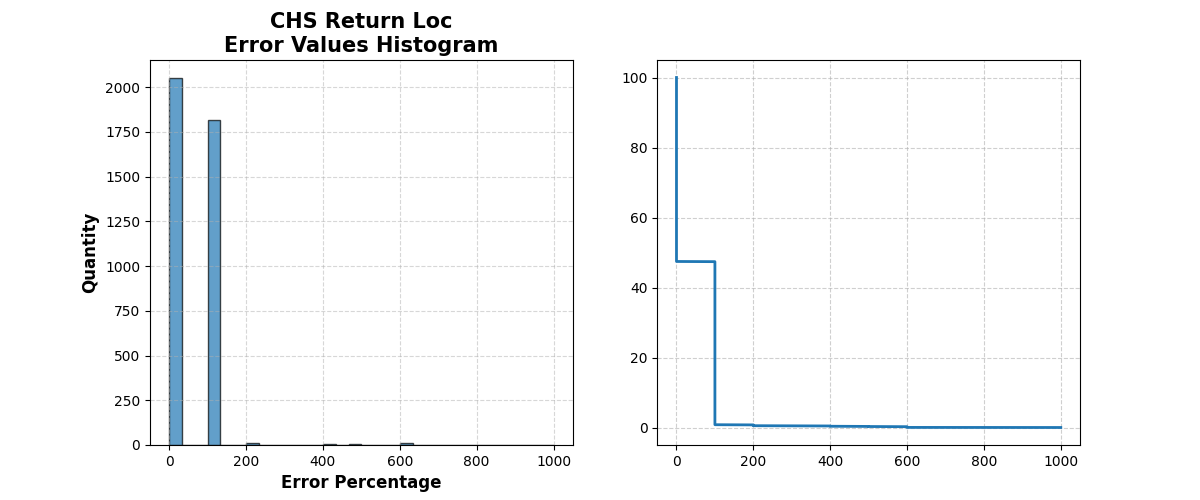

Text(615.6199494949494, 0.5, 'Data Percentage')

In [237]:
# Run train and test on whole data with a single XBGoost model

target_column = 'CHS Return Loc'
test_size = .1
__, y_test, y_pred = train_xgboost(DATA, target_column, test_size, RegressionORPrediction=0, random_state=42)

Error = 100 * abs(y_pred - y_test)

plt.clf()
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(Error, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title(f"{target_column}\nError Values Histogram", fontweight='bold', fontsize = 15)
axes[0].set_xlabel("Error Percentage", fontweight='bold', fontsize = 12)
axes[0].set_ylabel("Quantity", fontweight='bold', fontsize = 12)
axes[0].grid(True, linestyle='--', alpha=0.5)

Display_CDF(np.sort(Error)[::-1], axes[1])
axes[1].set_title('Error Values CDF', fontweight='bold', fontsize = 15)
axes[1].set_xlabel('Error Value', fontweight='bold', fontsize = 12)
axes[1].set_ylabel('Data Percentage', fontweight='bold', fontsize = 12)


In [ ]:
# Run the same as previous block but on a temporal timeline (train and test on a sliding window)
# The value to be displayed at each point is the percentage of the lines that are under a selected error percentage threshold (20%)

def sliding_xgb_window_eval(df, target_col, window_size, step, test_frac=0.2,
                            error_threshold=20.0, xgb_params=None, random_state=42,
                            min_test_samples=2, show_progress=False):
    """
    Slide a fixed-size window over df, train XGBRegressor on the first (1-test_frac)
    fraction and test on the last test_frac fraction. For each window compute the
    percentage of test rows whose percentage error <= error_threshold.

    Returns a DataFrame with columns:
      window_idx, start, end, n_test, pct_under_threshold
    """
    import math
    from tqdm import tqdm
    from xgboost import XGBRegressor, XGBClassifier

    if xgb_params is None:
        xgb_params = {'n_estimators': 100, 'random_state': random_state, 'verbosity': 0}

    results = []
    n = len(df)
    if window_size > n:
        raise ValueError("window_size larger than dataframe length")

    indices = range(0, n - window_size + 1, step)
    iterator = tqdm(indices) if show_progress else indices
    wi = 0

    print('Training and predicting for sliding windows...')
    for start in tqdm(iterator):
        end = start + window_size  # exclusive
        window = df.iloc[start:end].copy()

        # drop rows missing target
        window = window.dropna(subset=[target_col])
        if len(window) < 2:
            continue

        # prepare features (dummies on full window to keep alignment)
        X_all = pd.get_dummies(window.drop(columns=[target_col]), drop_first=True)
        y_all = window[target_col].astype(float).values
        # y_all = window[target_col].astype(int).values

        split_idx = int(math.floor((1.0 - test_frac) * len(window)))
        # ensure at least min_test_samples in test
        if len(window) - split_idx < min_test_samples or split_idx < 1:
            # skip window too small
            continue

        X_train = X_all.iloc[:split_idx, :].values
        y_train = y_all[:split_idx]
        X_test = X_all.iloc[split_idx:, :].values
        y_test = y_all[split_idx:]

        # train
        model = XGBRegressor(**xgb_params)
        # model = XGBClassifier(**xgb_params)
        # try:
        #     model.fit(X_train, y_train)   
        # except Exception as e:
        #     pass

        # predict
        y_pred = model.predict(X_test)

        # compute percent error safely:
        abs_diff = np.abs(y_test - y_pred)
        # If true value is zero, define percent error as 0 if prediction equals, else 100.
        pct_err = np.where(
            np.isclose(y_test, 0.0),
            np.where(np.isclose(abs_diff, 0.0), 0.0, 100.0),
            100.0 * abs_diff / np.abs(y_test)
        )

        pct_under = 100.0 * float(np.sum(pct_err <= error_threshold)) / len(pct_err)

        results.append({
            'window_idx': wi,
            'start': start,
            'end': end,
            'n_test': len(pct_err),
            'pct_under_threshold': pct_under
        })

        wi += 1

    print('DONE.')

    return pd.DataFrame(results).sort_values('window_idx').reset_index(drop=True)

window_size = 1000
step = 100
test_frac = .2
Error_Threshold = 20
Results_DF = sliding_xgb_window_eval(DATA, target_column, window_size, step, test_frac,
                            Error_Threshold, xgb_params=None, random_state=42,
                            min_test_samples=2, show_progress=False)


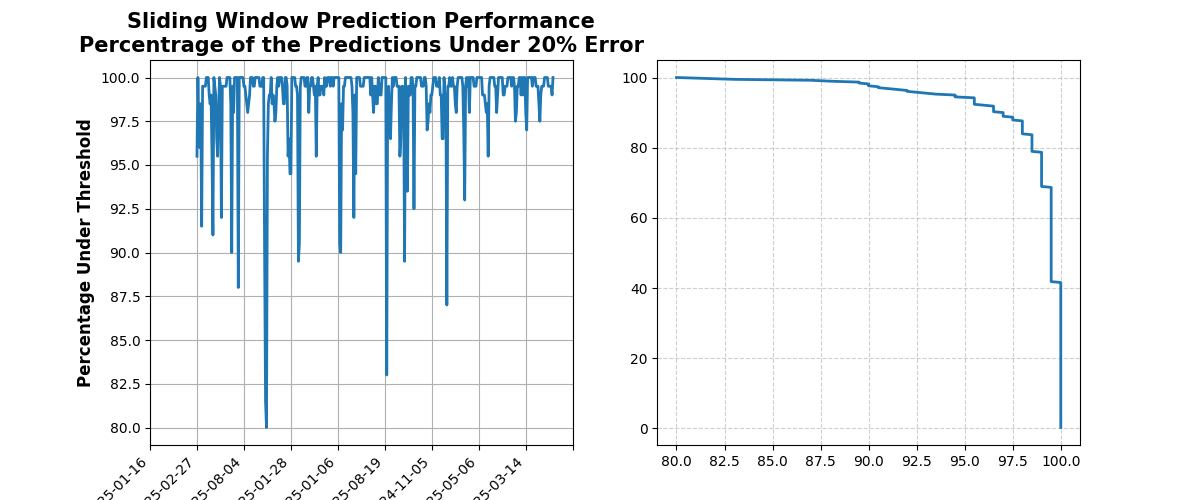

In [223]:
# Analyze the results of the temporal predcition

plt.clf()
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(Results_DF['start'], Results_DF['pct_under_threshold'], linewidth=2)
X_Indexes = axes[0].get_xticks()
X_Labels = [datetime.strftime(DATA_ORIG.iloc[int(x)][Sorting_Field], '%Y-%m-%d') if x < len(DATA) else '' for x in X_Indexes]    
axes[0].set_xticks(X_Indexes)
axes[0].set_xticklabels(X_Labels, rotation=45, ha='right')
axes[0].set_xlabel('Time', fontweight='bold', fontsize = 12)
axes[0].set_ylabel('Percentage Under Threshold', fontweight='bold', fontsize = 12)
axes[0].set_title(f'Sliding Window Prediction Performance\nPercentrage of the Predictions Under {Error_Threshold}% Error', fontweight='bold', fontsize = 15)
axes[0].grid()

plt.subplot(1, 2, 2)
CDF, ax1 = Display_CDF(Results_DF['pct_under_threshold'].sort_values(), axes[1])
axes[1].set_xlabel(f'Percentage Under {Error_Threshold}% \nError Threshold[%]', fontweight='bold', fontsize = 12)
axes[1].set_ylabel('Percentage [%]', fontweight='bold', fontsize = 12)
axes[1].set_title('Sliding Window Prediction Performance CDF', fontweight='bold', fontsize=15)

plt.tight_layout()


### Prediction Model 2 - Simple XBGoost on data divided into ranges by loan period length (Exploratory step only)

In [69]:
# Generate the ranges DataFrame

Bins_No = 10
Column_Name = Diff_Col_Name
__, Ranges = np.histogram(DATA[Column_Name], bins=Bins_No)

#region Extend ranges to include time epochs between 0 and first entry above zero

Time_Factor = 1
if Units=='Hours':
    Time_Factor = 24
Ranges *= Time_Factor

Ranges = list(Ranges)

if Ranges[1] > Time_Factor:
    Ranges_Rest = Ranges[1:]
    Ranges = list(np.arange(0, int(Ranges[1]), Time_Factor))
    Ranges.extend(Ranges_Rest)

#endregion

DF_LIST, RANGES = Divide_ARR_2_Arrays_by_Range(DATA, Column_Name, Ranges)


Generating Error Percentage arrays...


100%|██████████| 31/31 [00:02<00:00, 14.10it/s]

DONE


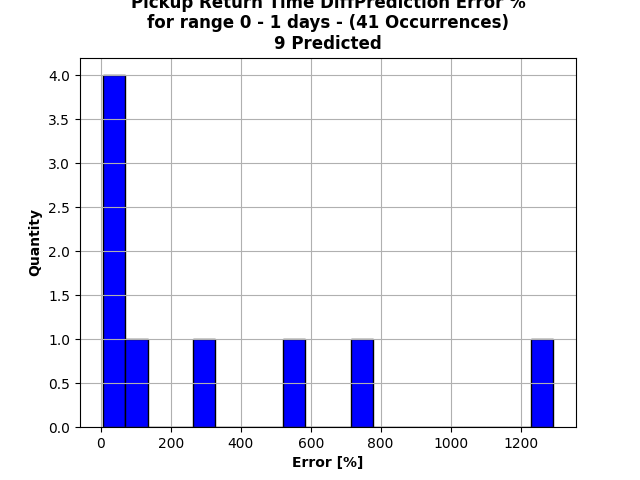

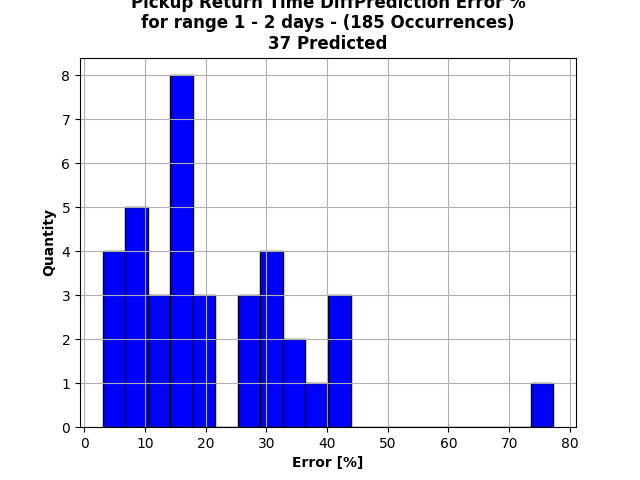

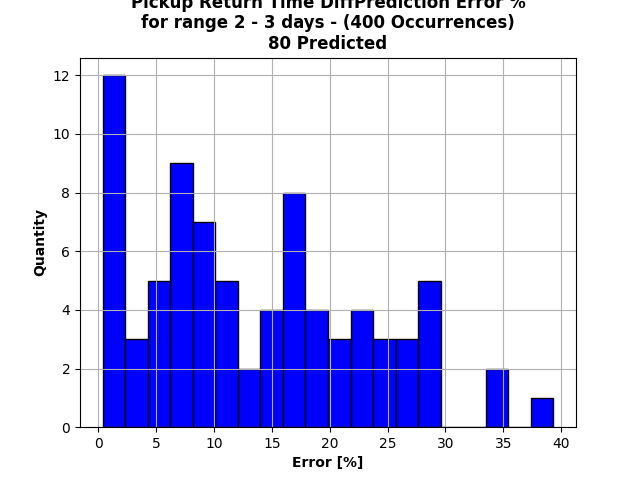

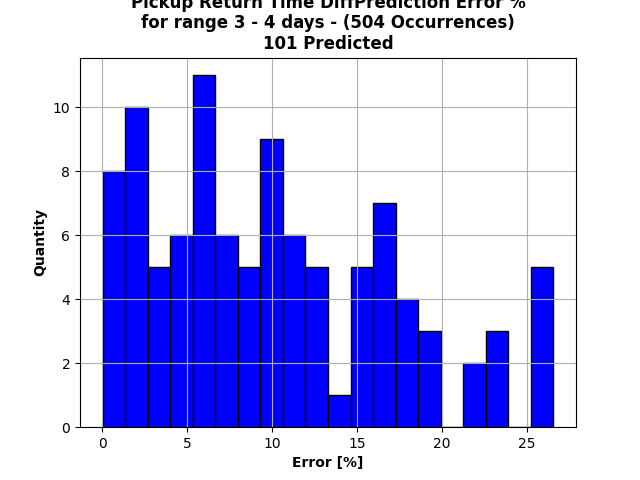

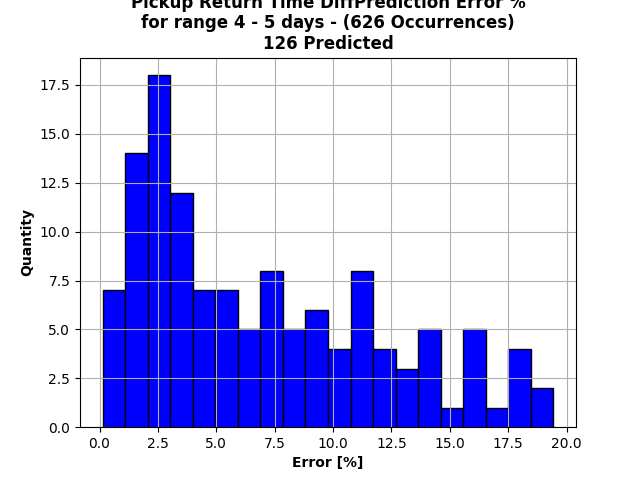

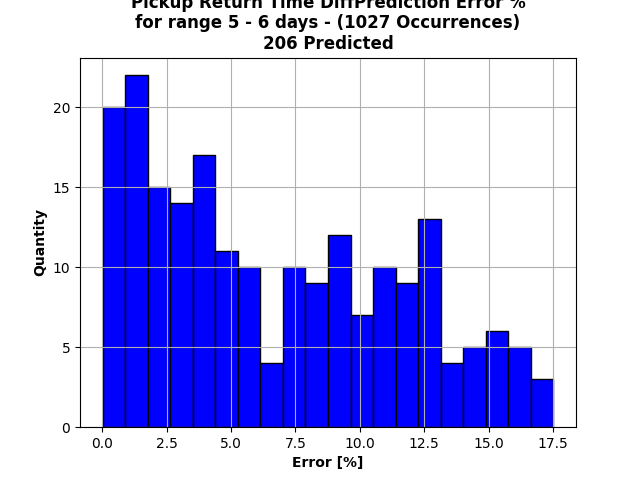

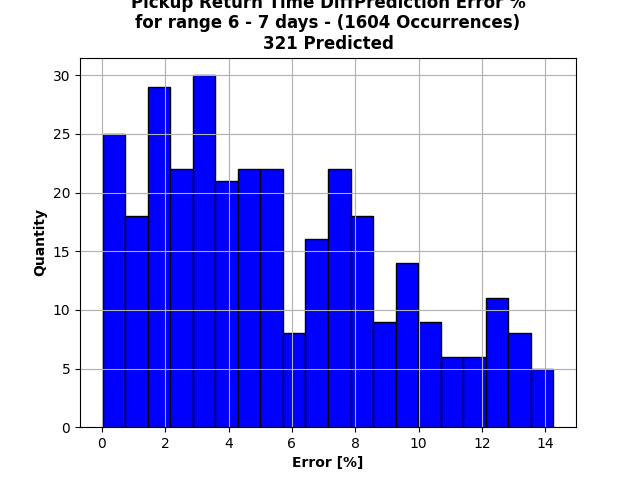

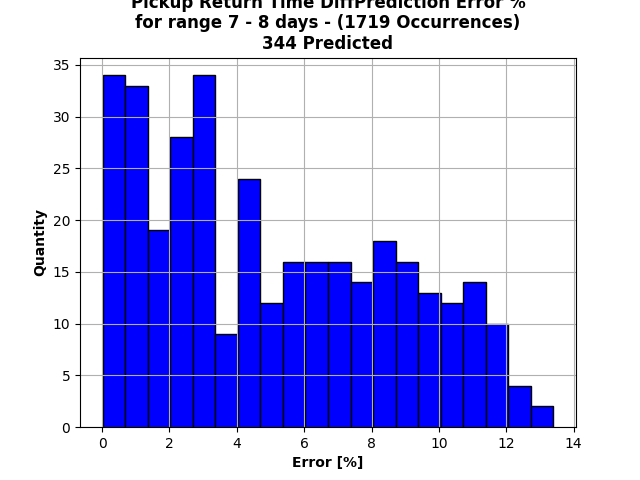

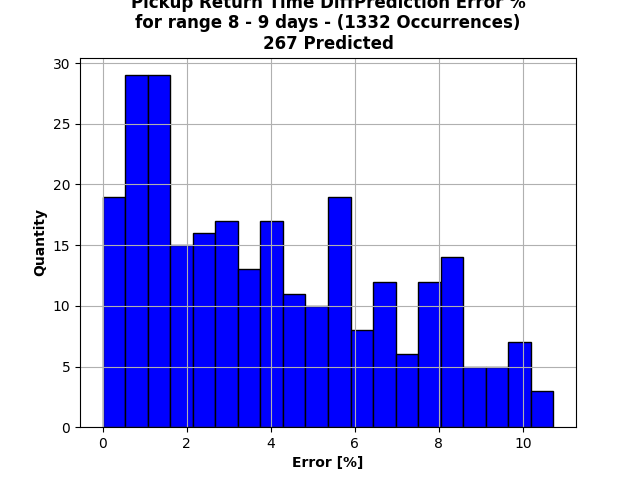

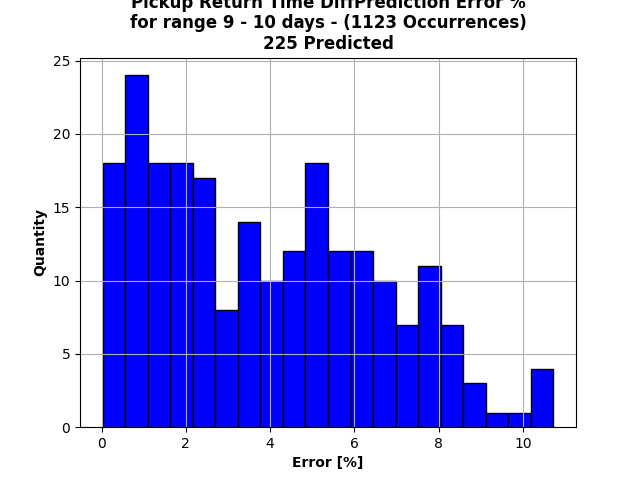

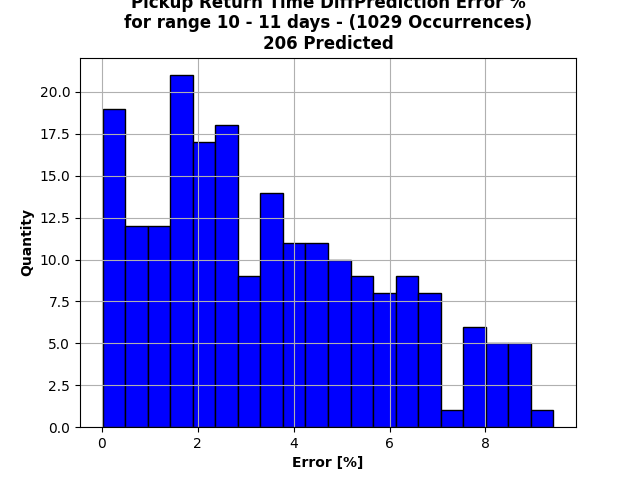

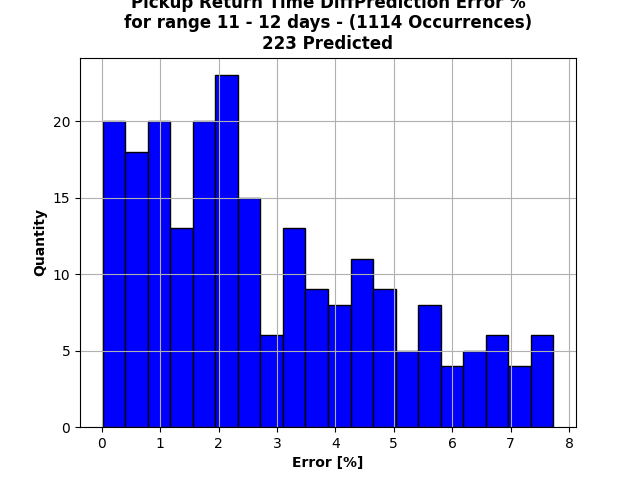

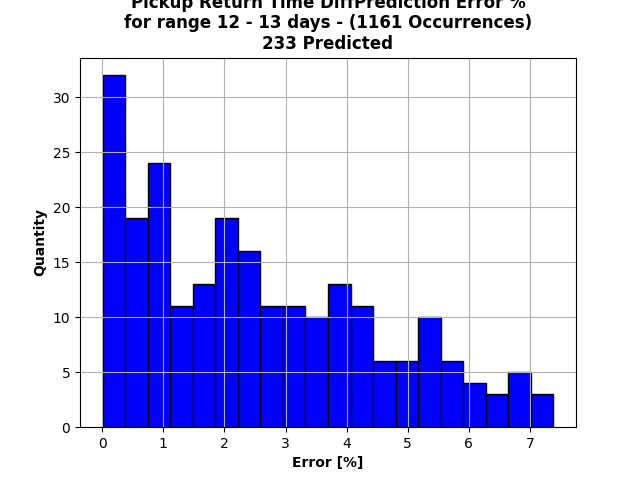

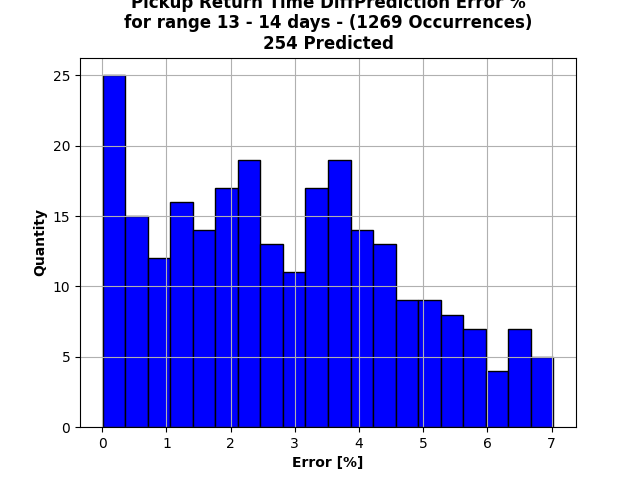

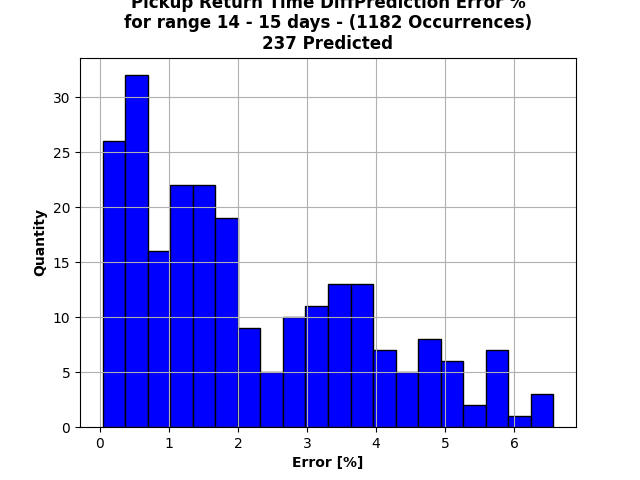

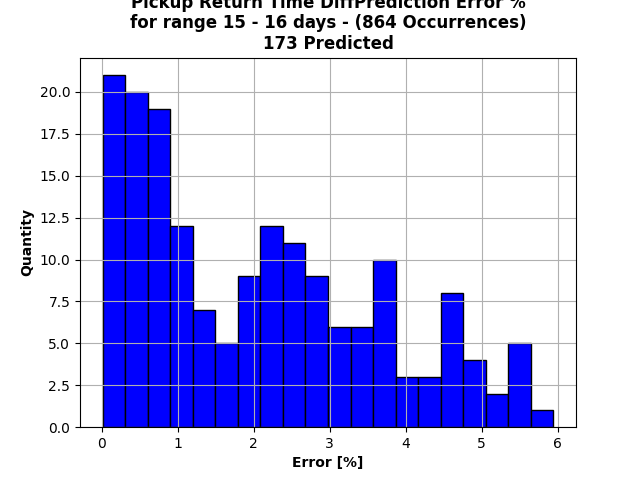

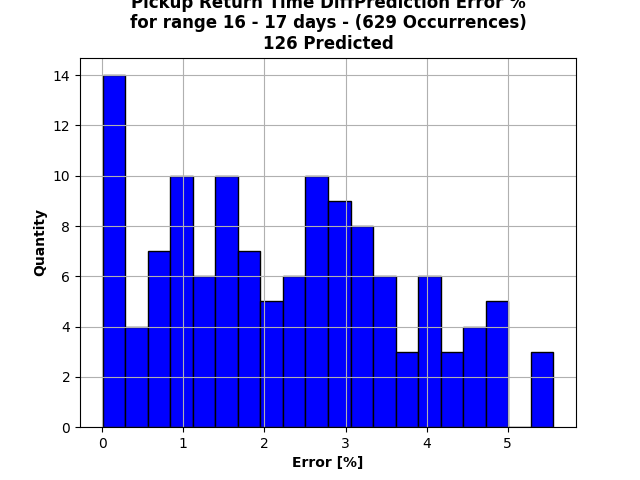

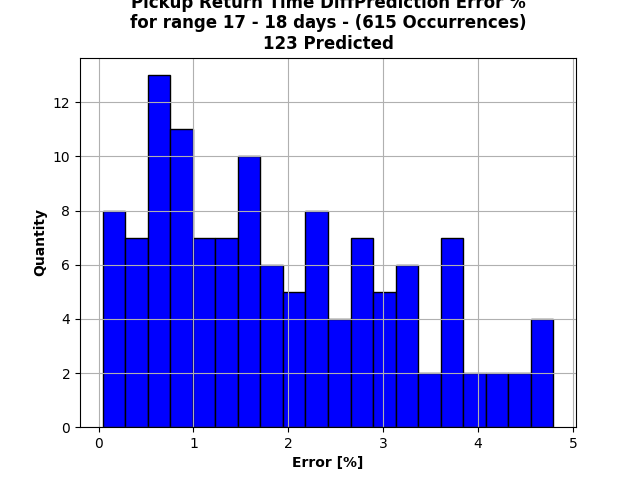

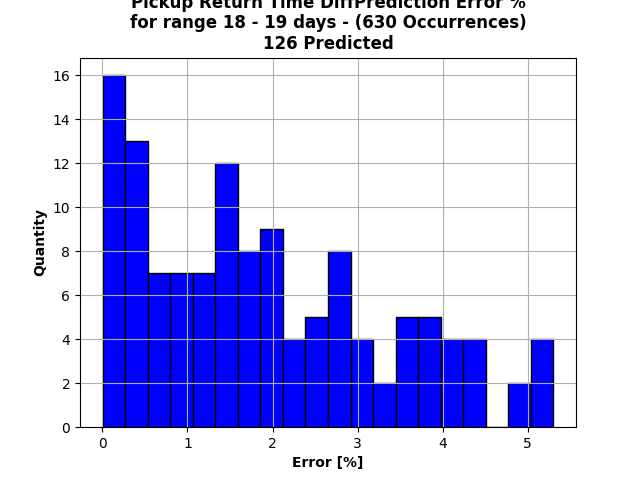

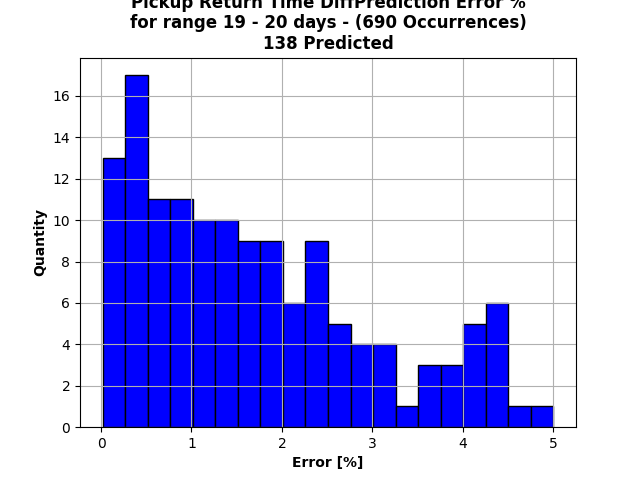

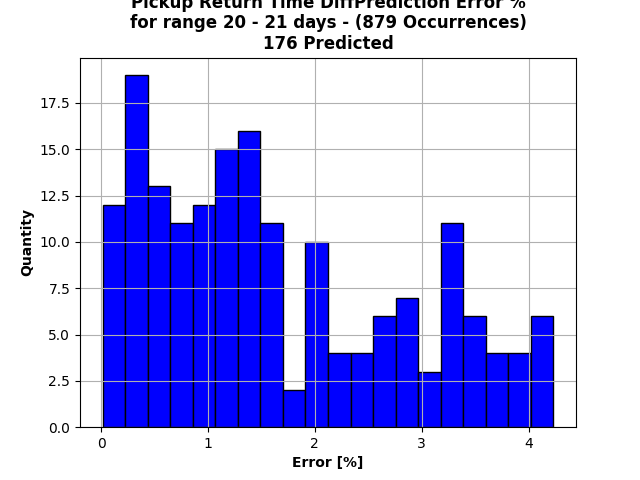

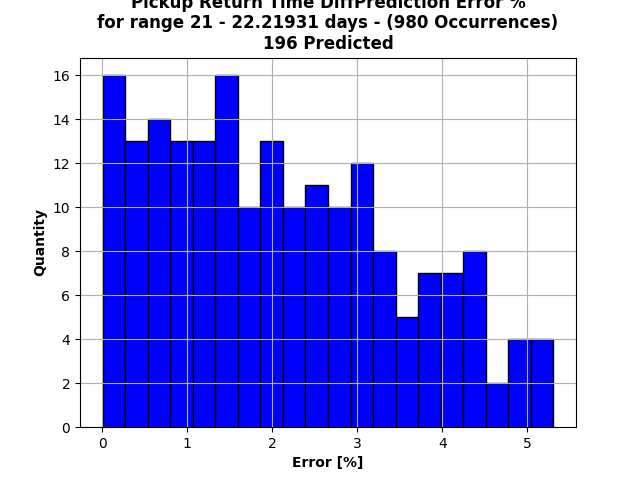

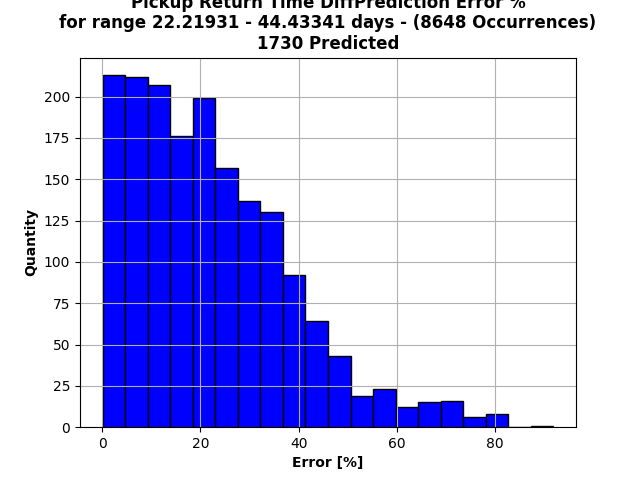

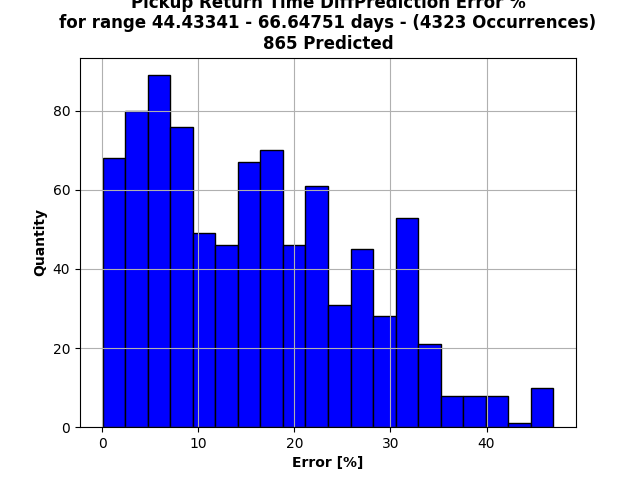

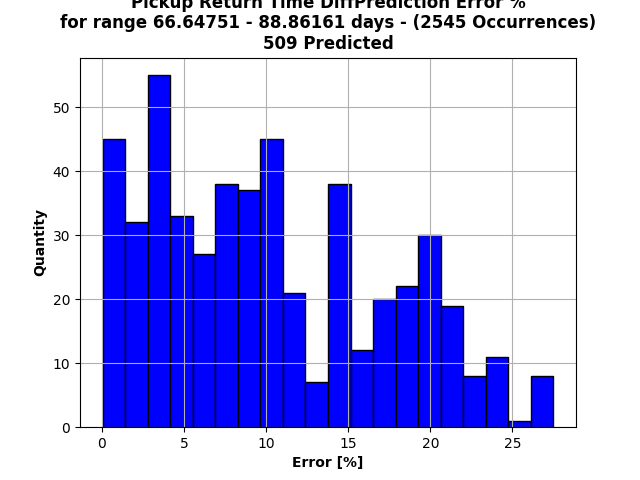

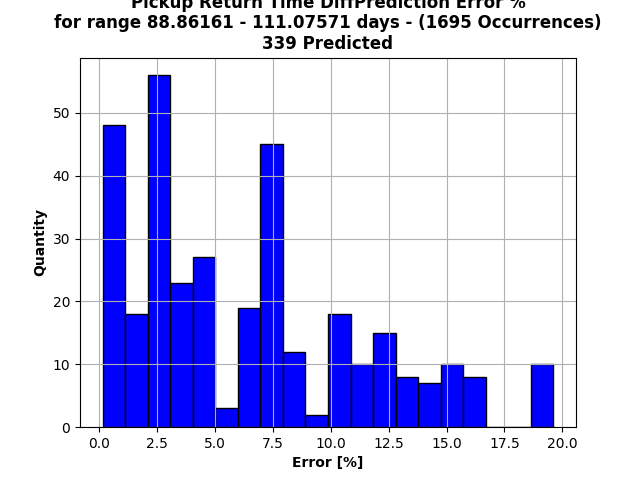

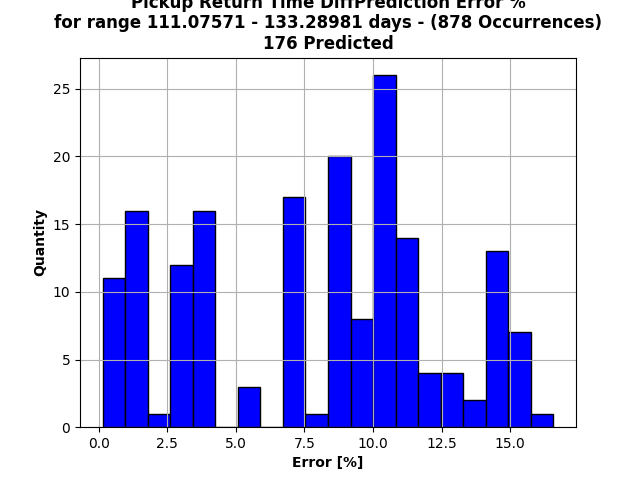

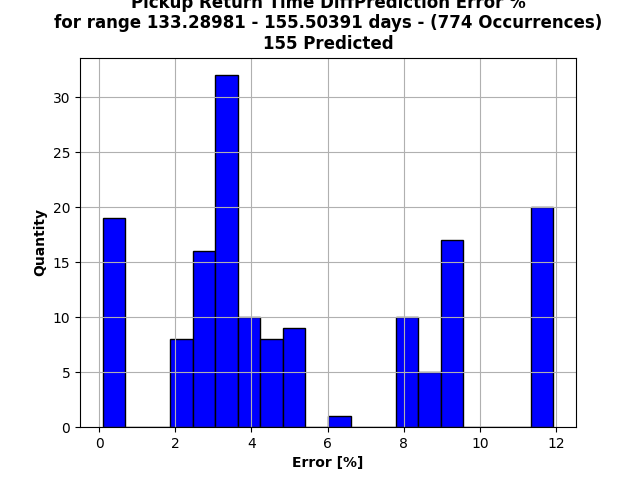

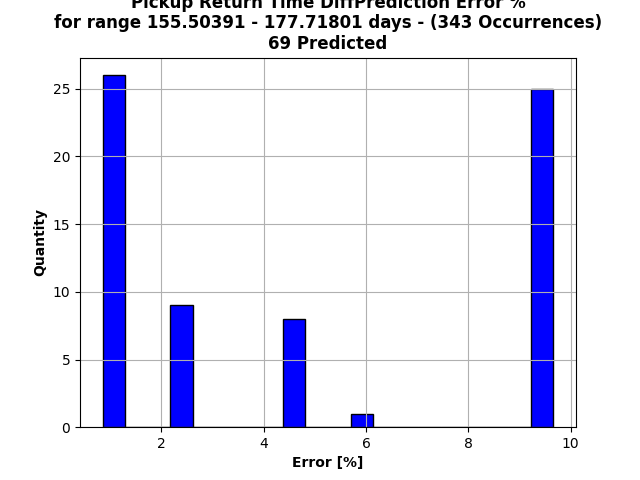

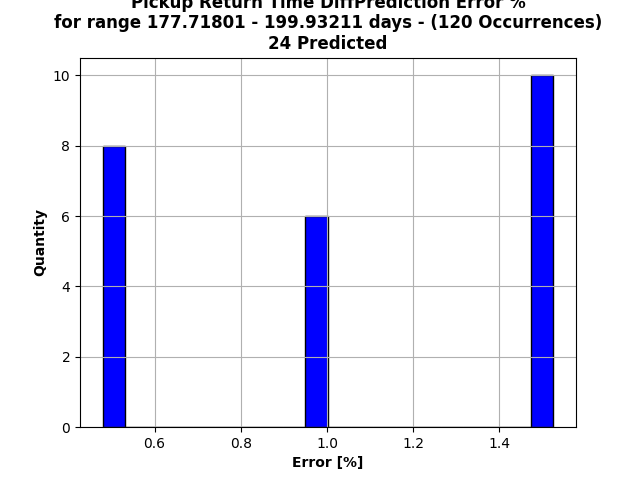

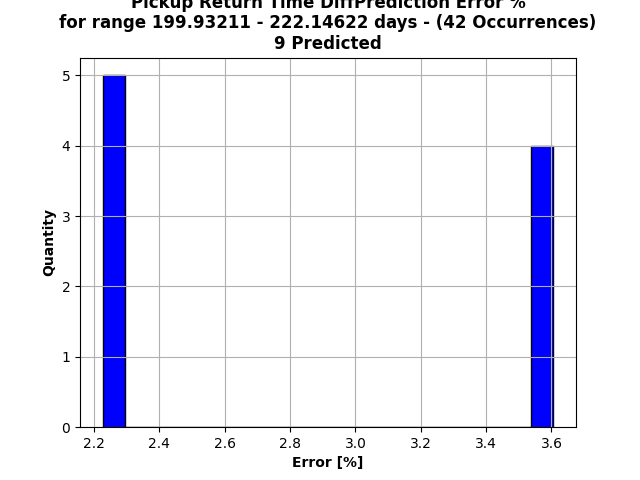

In [ ]:
# Run train and test for each of the ranges

AXES_LIST = []
for jj in range(len(RANGES)):
    fig, ax = plt.subplots()
    AXES_LIST.append(ax)

Target_Column = Diff_Col_Name
Test_Size = .2
Error_Per_REPO = []
Predicted_Quantities = []
jj = 0
print('Generating Error Percentage arrays...')

for DATA in tqdm(DF_LIST):
    model, y_test, y_pred = train_xgboost(DATA, Target_Column, Test_Size)

    # Analyze results and display error - error % for trip time and accuracy for the locations

    #region trip dureation error percentage

    Error_Per = np.zeros(len(y_pred))
    for ii in range(len(Error_Per)):
        True_Val = y_test.iloc[ii]
        Pred_Val = y_pred[ii]
        Error_Per[ii] = abs(True_Val - Pred_Val) / True_Val * 100
        
    Error_Per_REPO.append(Error_Per)            # Collect for analysis in next block
    Predicted_Quantities.append(len(y_pred))

    # print(f'Original array length: {Error_Per.shape[0]}')
    # Truncate_Pecentage = 300
    # Error_Per = Error_Per[Error_Per<=Truncate_Pecentage]
    # print(f'Truncated (less then {Truncate_Pecentage}% error) array length: {Error_Per.shape[0]}')

    # print(f'Max(Error_Per) = {np.max(Error_Per):.2f} %')
    # print(f'Min(Error_Per) = {np.min(Error_Per):.2f} %')
    # print(f'{100* (Error_Per[Error_Per<100]).shape[0] / Error_Per.shape[0]}% of values are under 100% error')
    
    AXES_LIST[jj].hist(Error_Per, bins=20, color='blue', edgecolor='black')
    # AXES_LIST[jj].set_title(f'Pickup Return Time Diff Prediction Error % for range\n{np.round(RANGES[jj][0], 5)} - {np.round(RANGES[jj][1], 5)} days', fontweight='bold', fontsize=15)
    AXES_LIST[jj].set_title(f'Pickup Return Time DiffPrediction Error %\nfor range {np.round(RANGES[jj][0], 5)} - {np.round(RANGES[jj][1], 5)} days - ({len(DATA)} Occurrences)\n{len(y_pred)} Predicted', fontweight='bold', fontsize=12)
    
    AXES_LIST[jj].set_xlabel('Error [%]', fontweight='bold', fontsize=10)
    AXES_LIST[jj].set_ylabel('Quantity', fontweight='bold', fontsize=10)
    AXES_LIST[jj].grid()

    jj += 1

print('DONE')

#endregion


#### Analyze Error arrays from all time ranges
##### This section goes through each of the error arrays and checks the max error % that 90% (configurable)
##### of the values reside under and displays those figures in a plot

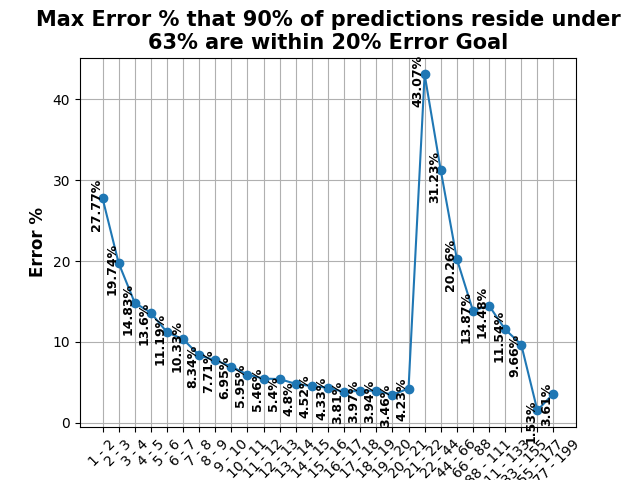

In [ ]:
# Get the max value that 90% f the error values reside under

Threshold_Percentile = 90
Results_ARR = []
RANGE_STR_ARR = []
LABELS = []
Start_Range_Index = 1

Final_ACC_Goal = 20
Coverage = 0
Quantities_Total = 0

for ii, Error_Per in enumerate(Error_Per_REPO[Start_Range_Index:]):
    if ii>=Start_Range_Index:
        Results_ARR.append(np.percentile(Error_Per, Threshold_Percentile))
        RANGE_STR_ARR.append(f'{int(RANGES[ii][0])} - {int(RANGES[ii][1])}')
        LABELS.append(str(Results_ARR[-1].round(2)))

        if Results_ARR[-1]<=Final_ACC_Goal:
            Coverage += Predicted_Quantities[ii]

        Quantities_Total +=Predicted_Quantities[ii]

fig, ax = plt.subplots()
ax.plot(range(len(Results_ARR)), Results_ARR, marker='o', linestyle='-')
ax.set_title(f'Max Error % that {Threshold_Percentile}% of predictions reside under\n{int(100*Coverage/Quantities_Total)}% are within {Final_ACC_Goal}% Error Goal', fontweight='bold', fontsize=15)
ax.set_xlabel('Time Range Index', fontweight='bold', fontsize=12)
ax.set_ylabel('Error %', fontweight='bold', fontsize=12)
ax.set_xticks(range(len(Results_ARR)))
ax.set_xticklabels(RANGE_STR_ARR, rotation=45)

for xi, yi, label in zip(range(len(Results_ARR)), Results_ARR, LABELS):
    ax.text(xi, yi-4, f'{label}%', fontweight='bold', fontsize=9, ha='right', va='bottom', rotation=90)
ax.grid()
